# Machine learning for trading (Gold)


## Data loading


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import warnings
warnings.filterwarnings('ignore')


In [2]:
## Load yfinance Gold data
yf = False

if yf:
  import yfinance as yf
  # Define the ticker symbol
  tickerSymbol = 'GC=F'
  # Get the data for this ticker
  tickerData = yf.Ticker(tickerSymbol)
  # Get the historical prices for this ticker
  data = tickerData.history(period='1d', start='2012-7-12')
else:
  data = pd.read_csv('gc_data_2012_2023_tradingview.csv', parse_dates=['Date'], index_col='Date')


In [3]:
data

,open,high,low,close
Date,,,,
2011-04-17 22:00:00+00:00,1488.0,1498.6,1477.8,1492.9
2011-04-18 22:00:00+00:00,1496.6,1500.5,1488.2,1495.1
2011-04-19 22:00:00+00:00,1496.1,1506.5,1493.8,1498.9
2011-04-20 22:00:00+00:00,1502.0,1509.6,1500.4,1503.8
2011-04-24 22:00:00+00:00,1510.7,1519.2,1502.2,1509.1
...,...,...,...,...
2023-07-27 22:00:00+00:00,1985.3,2002.0,1983.9,1999.9
2023-07-30 22:00:00+00:00,1997.9,2010.9,1986.7,2009.2
2023-07-31 22:00:00+00:00,2004.2,2004.4,1978.3,1982.3


## Check GPU


In [4]:
if yf:
  data = data.drop(['Dividends','Volume', 'Stock Splits'],axis = 1)
  data.columns = ['Open', 'High', 'Low', 'Close']
else:
  data.columns = ['Open', 'High', 'Low', 'Close']
  data['Close'] = data['Close'].astype(float)
  data['Open'] = data['Open'].astype(float)
  data['High'] = data['High'].astype(float)
  data['Low'] = data['Low'].astype(float)

data = data.dropna()
data = data.sort_values(by="Date", ascending=True)
#data.to_csv('gcdata.csv')
#data.columns = ['Date','Open', 'High', 'Low', 'Close']


## Plotting the market data


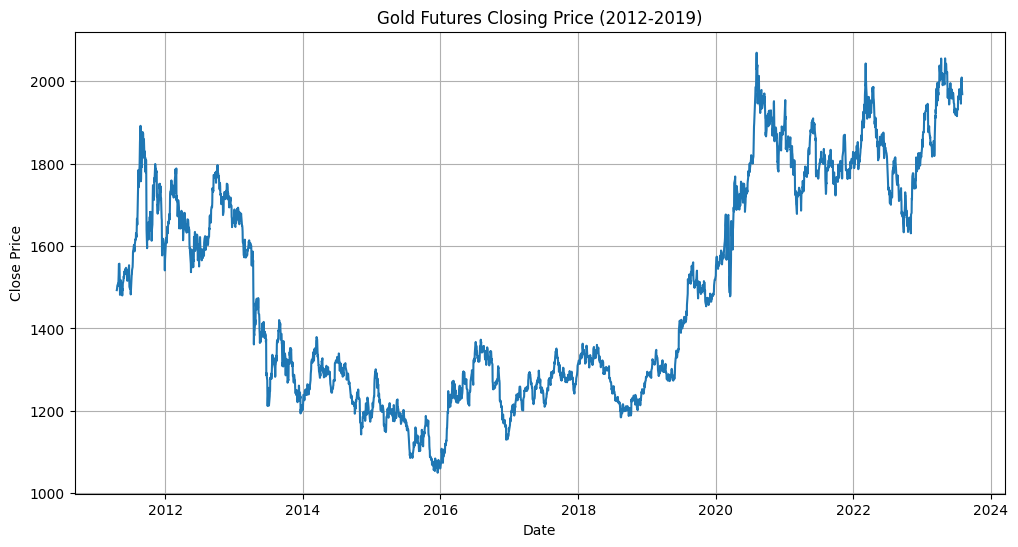

In [5]:
# Plotting
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title('Gold Futures Closing Price (2012-2019)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [6]:
data_raw = data.copy()

In [7]:
data_raw.head()

,Open,High,Low,Close
Date,,,,
2011-04-17 22:00:00+00:00,1488.0,1498.6,1477.8,1492.9
2011-04-18 22:00:00+00:00,1496.6,1500.5,1488.2,1495.1
2011-04-19 22:00:00+00:00,1496.1,1506.5,1493.8,1498.9
2011-04-20 22:00:00+00:00,1502.0,1509.6,1500.4,1503.8
2011-04-24 22:00:00+00:00,1510.7,1519.2,1502.2,1509.1


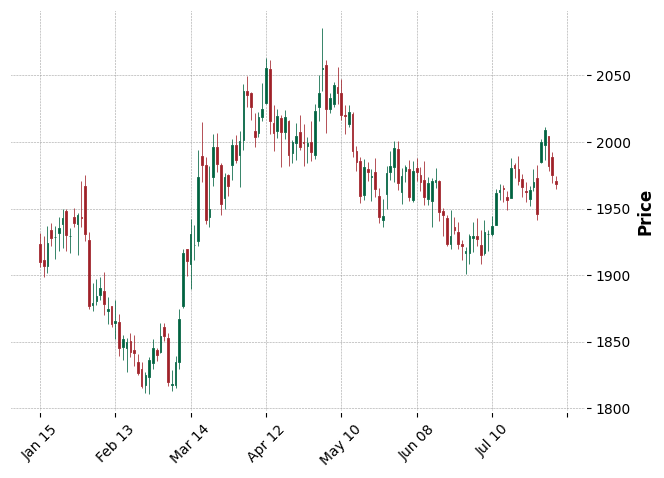

In [8]:
import mplfinance as mpf
mpf.plot(data.loc['01-13-2023':],type='candle', style='charles')

In [9]:
#data_raw.to_csv("gc_data_2012_2023Jul.csv")

## Defining the features


In [10]:
#defining the features
def featurize(data, fast=7, slow=21, twoslow=35):
  data['Close_1'] = data['Close'].shift(1)
  data['Open_1'] = data['Open'].shift(1)
  data['maFast'] = data['Close'].ewm(span=fast, adjust=False).mean()
  data['maSlow'] = data['Close'].ewm(span=slow, adjust=False).mean()
  data['ma2Slow'] = data['Close'].ewm(span=twoslow, adjust=False).mean()
  data['closeMinusMaFast'] = data.Close - data.maFast
  data['close1MinusMaFast'] = data.Close_1 - data.maFast
  data['closeMinusMaSlow'] = data.Close - data.maSlow
  #data['close1MinusMaSlow'] = data.Close_1 - data.maSlow
  data['MaFastMinusMaSlow'] = data.maFast - data.maSlow
  data['closeMinusHigh_7'] = data.Close - data.High.shift(7)
  data['closeMinusLow_7'] = data.Close - data.Low.shift(7)
  data['lowMinusLow_7'] = data.Low - data.Low.shift(7)
  #data['highMinusHigh_7'] = data.High - data.High.shift(7)
  data['MaFastMinusMa2Slow'] = data.maFast - data.ma2Slow
  data['MaSlowMinusMa2Slow'] = data.maSlow - data.ma2Slow
  data['returnToday'] = abs(data.Close - data.Open)
  data['returnNextDay'] = data.returnToday.shift(-1)

  returnRange = data.Close - data.Open
  data['candleToday'] = [1 if var > 0 else 0 for var in returnRange]
  data['candleNextDay'] = data.candleToday.shift(-1)
  data['candleTarget'] = [1 if x > y else 0 for x,y in list(zip(data.Close, data.Open_1))]
  # Add lagged features for the closing price
  for i in range(1, 8):
      data[f'candlelag_{i}'] = data.candleToday.shift(i)
  data['sum_bull_lag'] = (data['candleToday'] + data['candlelag_1'] + data['candlelag_2'] + data['candlelag_3'] + data['candlelag_4'] + data['candlelag_5'])/6

  data['CloseTomaFast'] = [1 if var > i else 0 for var,i in list(zip(data.Close, data.maFast))]
  for i in range(1, 8):
      data[f'CloseTomaFast_{i}'] = data.CloseTomaFast.shift(i)
  data['sum_clvsemafast_lag'] = (data['CloseTomaFast'] + data['CloseTomaFast_1'] + data['CloseTomaFast_2'] + data['CloseTomaFast_3'] + data['CloseTomaFast_4'] + data['CloseTomaFast_5'])/6

  data['CloseTomaSlow'] = [1 if var > i else 0 for var,i in list(zip(data.Close, data.maSlow))]
  for i in range(1, 8):
      data[f'CloseTomaSlow_{i}'] = data.CloseTomaSlow.shift(i)
  data['sum_clvsemaslow_lag'] = (data['CloseTomaSlow'] + data['CloseTomaSlow_1'] + data['CloseTomaSlow_2'] + data['CloseTomaSlow_3'] + data['CloseTomaSlow_4'] + data['CloseTomaSlow_5'])/6

  data['maFastTomaSlow'] = [1 if var > i else 0 for var,i in list(zip(data.maFast, data.maSlow))]
  for i in range(1, 8):
      data[f'maFastTomaSlow_{i}'] = data.maFastTomaSlow.shift(i)
  data['sum_mafastvsemaslow_lag'] = (data['maFastTomaSlow'] + data['maFastTomaSlow_1'] + data['maFastTomaSlow_2'] + data['maFastTomaSlow_3'] + data['maFastTomaSlow_4'] + data['maFastTomaSlow_5'])/6


  return data

In [11]:
data.tail()

,Open,High,Low,Close
Date,,,,
2023-07-27 22:00:00+00:00,1985.3,2002.0,1983.9,1999.9
2023-07-30 22:00:00+00:00,1997.9,2010.9,1986.7,2009.2
2023-07-31 22:00:00+00:00,2004.2,2004.4,1978.3,1982.3
2023-08-01 22:00:00+00:00,1988.9,1992.2,1969.1,1975.0
2023-08-02 22:00:00+00:00,1970.8,1974.5,1964.5,1968.8


### other features


## Train and test set


In [26]:
drop_feature_list = ['Open','High','Low','Close','maFast','maSlow', 'ma2Slow','candleNextDay','returnNextDay','returnToday',
                       'candlelag_3', 'candlelag_4','candlelag_5', 'candlelag_6', 'CloseTomaFast_3',  'CloseTomaFast_4',
                       'CloseTomaFast_5',  'CloseTomaFast_6','CloseTomaSlow_3','CloseTomaSlow_4', 'CloseTomaSlow_5', 'CloseTomaSlow_6',
                       'candlelag_2', 'CloseTomaFast_2', 'CloseTomaSlow_2','maFastTomaSlow_2', 'maFastTomaSlow_3', 'maFastTomaSlow_4',
                       'maFastTomaSlow_5', 'maFastTomaSlow_6',
                       'Close_1','candleTarget', 'Open_1'
                        #'MaFastMinusMa2Slow'
                       ]

#normalise features
feature_list = ['MaFastMinusMaSlow', 'MaFastMinusMa2Slow', 'MaSlowMinusMa2Slow',
                  'closeMinusMaFast', 'closeMinusMaSlow', 'close1MinusMaFast',
                  'close1MinusMaSlow', 'closeMinusHigh_7', 'closeMinusLow_7',
                  'highMinusHigh_7', 'lowMinusLow_7']

def train_validate(data = data, tsplit=1000, estimators=1000, fast=7, slow=21, twoslow=35):

  #Generate features
  data = featurize(data, fast, slow, twoslow)
  data = data.dropna()

  #Define the training set
  X = data.drop(drop_feature_list, axis = 1)
  Y = data.candleNextDay
  returns = data.returnNextDay
  X.tail(5)

  #train_test split - temporal split
  tsplit = tsplit
  XTrain = X[:tsplit]
  YTrain = Y[:tsplit]
  returnsTrain = returns[:tsplit]
  XTest = X[tsplit+1:]
  YTest = Y[tsplit+1:]
  returnsTest = returns[tsplit+1:]

  #Normalize
  for feature in feature_list:
    if feature in XTrain.columns:
      minmaxsc_1 = MinMaxScaler()
      XTrain[feature] = minmaxsc_1.fit_transform(XTrain[feature].values.reshape(-1,1))
      XTest[feature] = minmaxsc_1.transform(XTest[feature].values.reshape(-1,1))
    else:
      pass

  #Function to Calculate the true return
  def predictedReturn(pred, YTest, returnsTest):
      results = pd.Series([res if var == i else -res for res,var,i in list(zip(returnsTest, pred, YTest))]) * 10
      results.index = YTest.index
      cumResults = results.cumsum() 
      cummax = cumResults.cummax()
      drawdown = cumResults - cummax
      return results, cumResults, drawdown

  #begin training and testing
  from sklearn.ensemble import RandomForestRegressor
  rf = RandomForestRegressor(n_estimators=estimators,
                                  random_state=1,
                                  n_jobs=-1)

  rf.fit(XTrain, YTrain)

  ## Making the predictions
  predRF = pd.Series(rf.predict(XTest))
  predRF = pd.Series([1 if var > 0.5 else 0 for var in predRF])
  predRF.index = YTest.index
  equityRF,cumEquityRF, drawdown = predictedReturn(predRF, YTest, returnsTest)



  clScaled = -500 + (data.Close[tsplit+1:] - data.Close[tsplit+1:].min()) / (data.Close[tsplit+1:].max() - data.Close[tsplit+1:].min()) * 1000

  # Calculate the confusion matrix and accuracy
  from sklearn.metrics import confusion_matrix, accuracy_score
  conf_matrix = confusion_matrix(YTest, predRF)
  accuracy = accuracy_score(YTest, predRF)
  #print(f'The accuracy is {round(accuracy*100,2)}%')

  ## Plot the cum equity curve
  if cumEquityRF.iloc[-1] > 1250:
    plt.figure()
    cumEquityRF.plot(figsize=(15, 7),  color = 'g')
    plt.plot(range(1,len(data.Close)-tsplit), clScaled, color = 'r', linestyle = 'dashed')
    plt.xlabel('number of trades')
    plt.ylabel('cum return (x10 USD)')
    plt.title(f'return for strategy {tsplit}-{estimators}-{fast}-{slow}-{twoslow} - acc: {round(accuracy, 2)}')

    plt.figure()
    drawdown.plot(figsize=(15, 7),  color = 'b')
    plt.ylabel('drawdown return (x100 USD)')


  cumEquityRF.index = XTest.index
  return rf, XTrain, cumEquityRF, equityRF, drawdown


In [27]:
test_all = False

if test_all:
  for ema in [28, 35, 42, 49, 56, 63]:
    for split in [300, 400, 500,600,700,800, 900, 1000, 1100, 1200]:
      for estimator in [1,2,3,5, 7, 15, 35, 65, 85, 115, 150, 195]:
        rf,XTrain,_,_,_= train_validate(data_raw, split,estimator, 7, 21, ema)

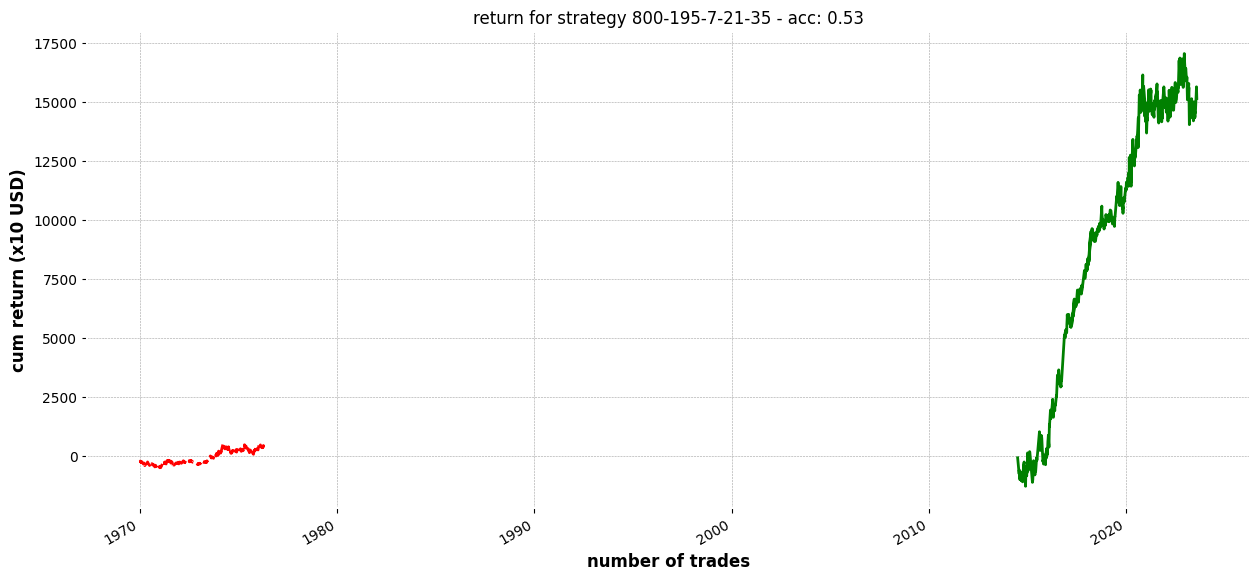

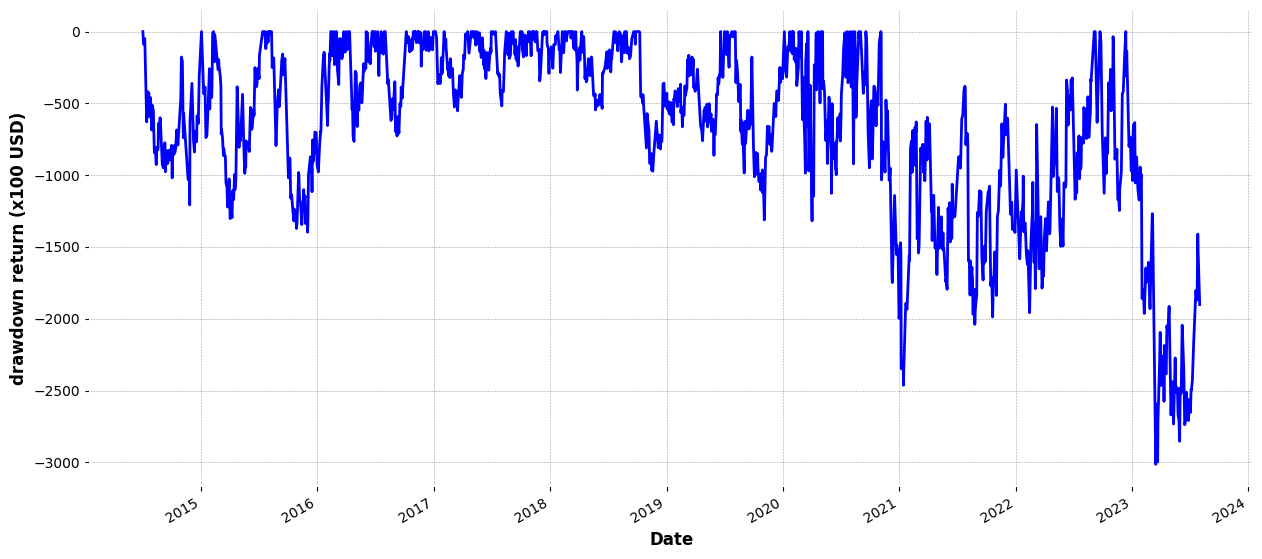

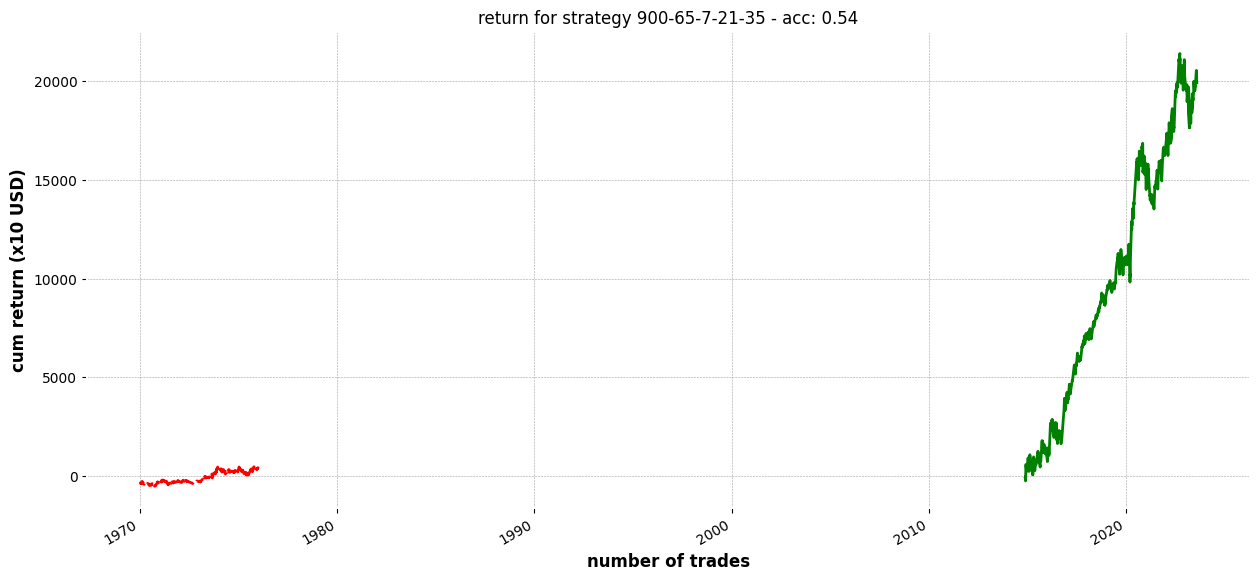

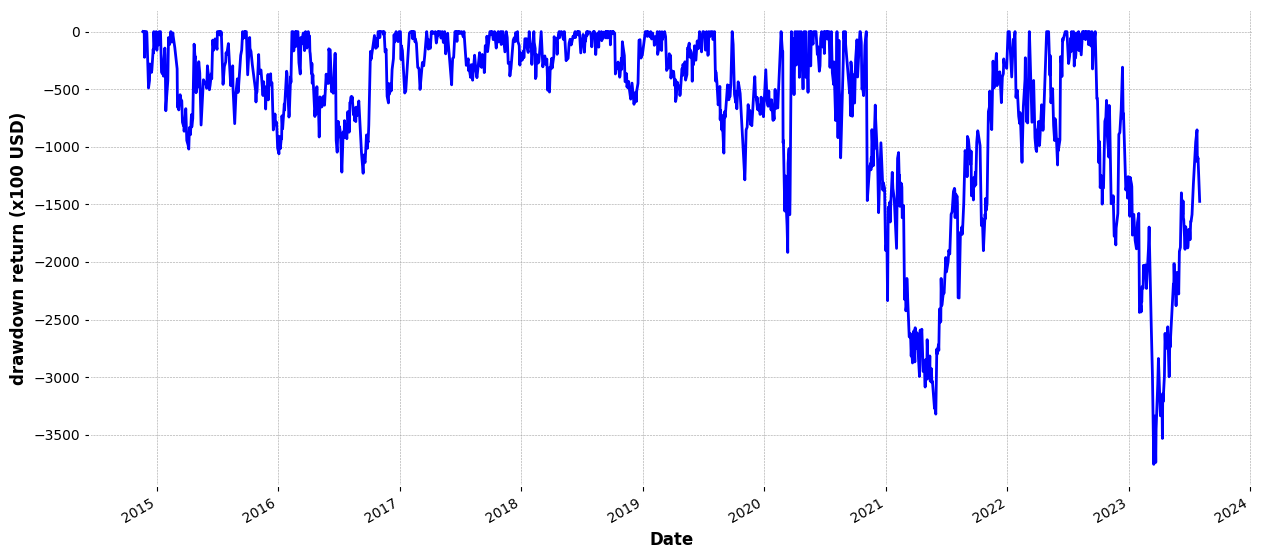

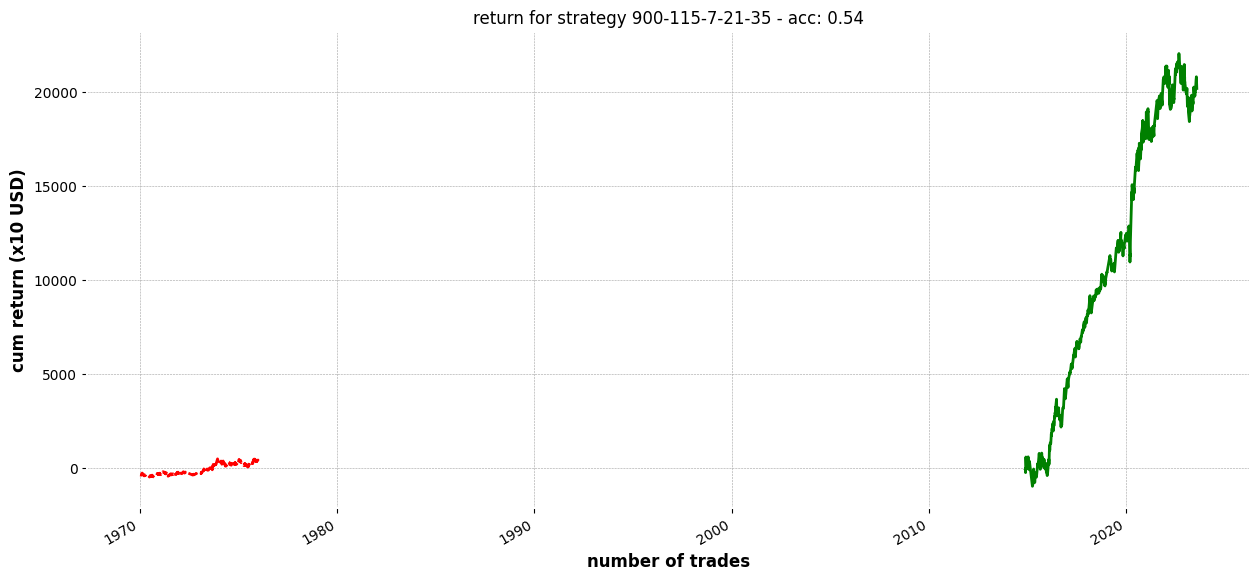

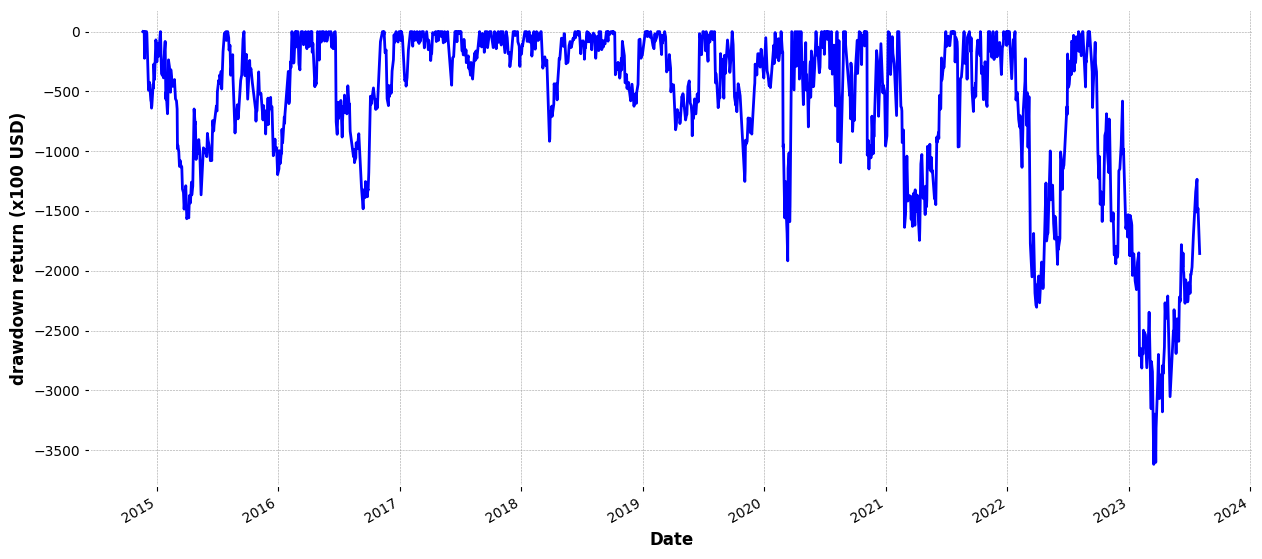

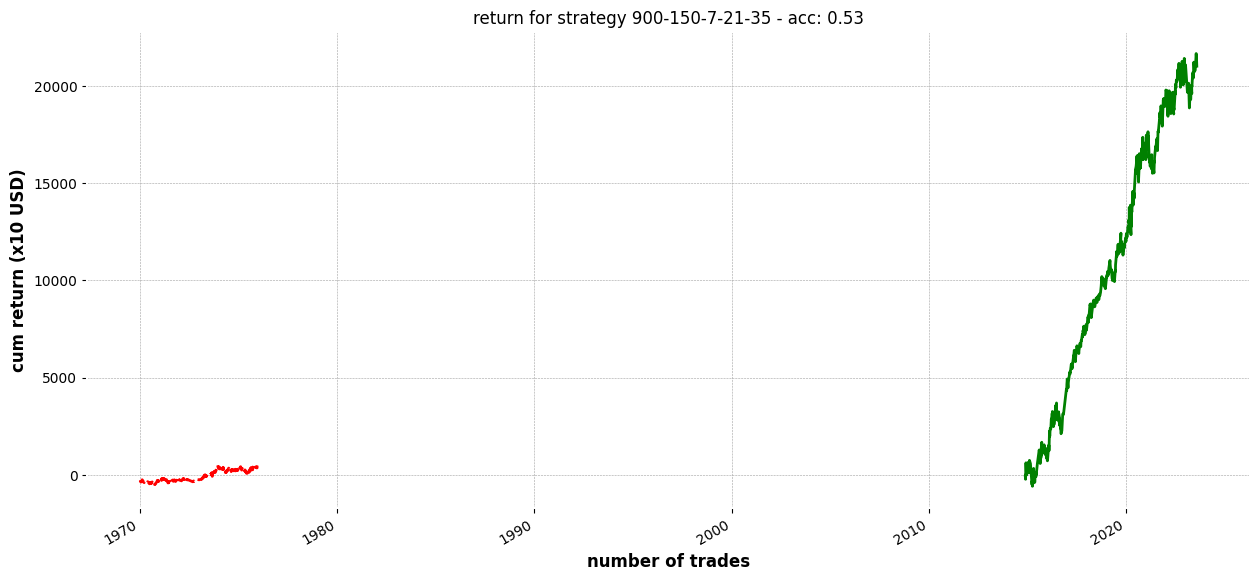

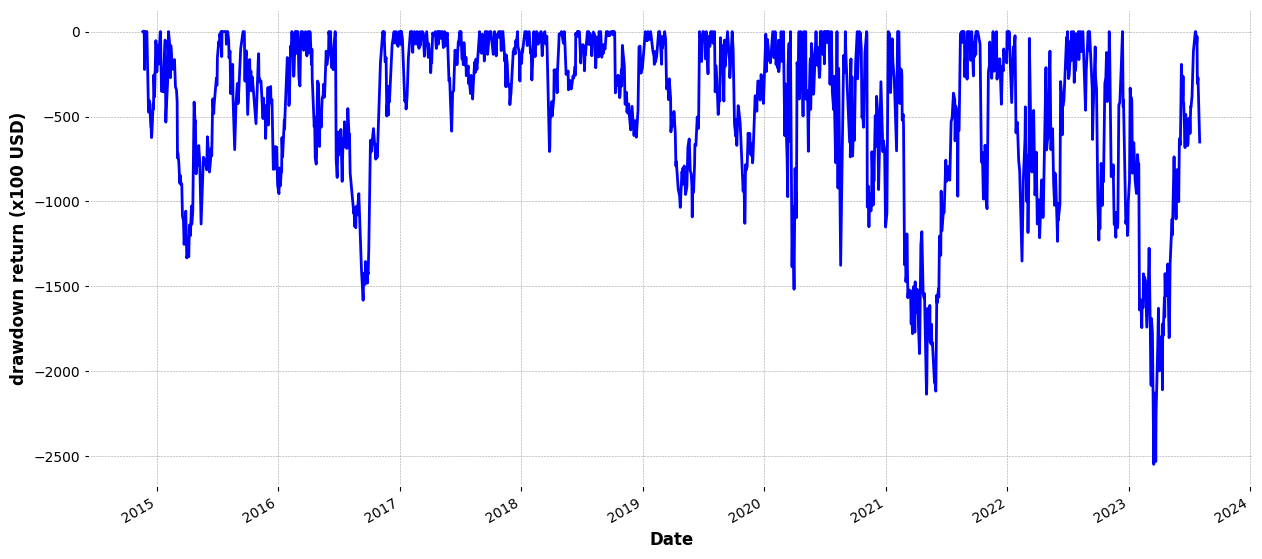

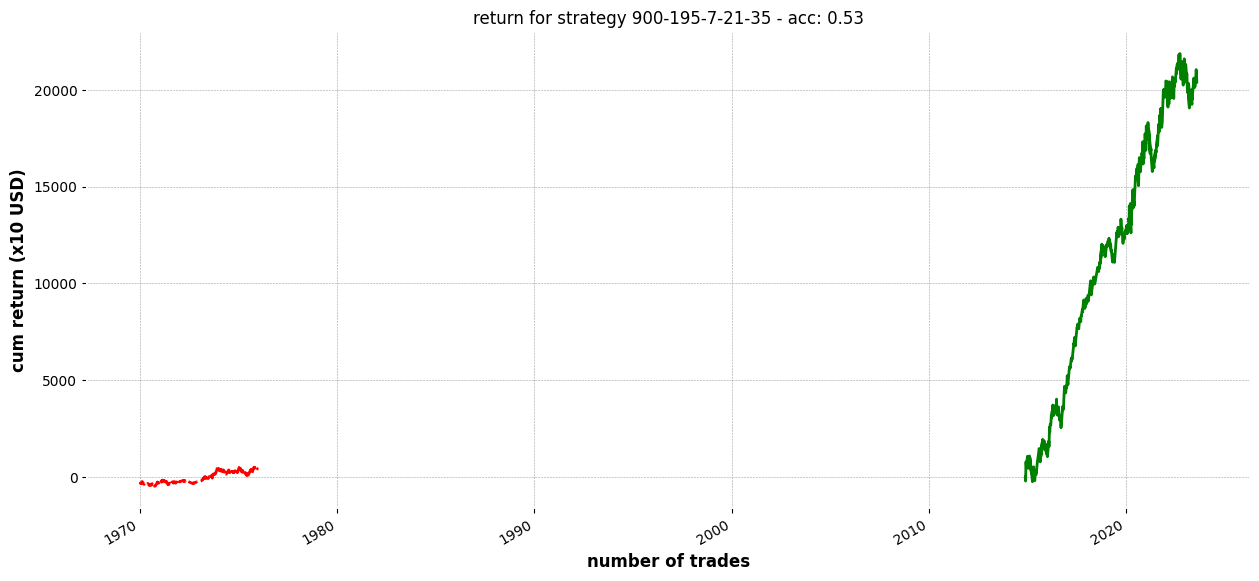

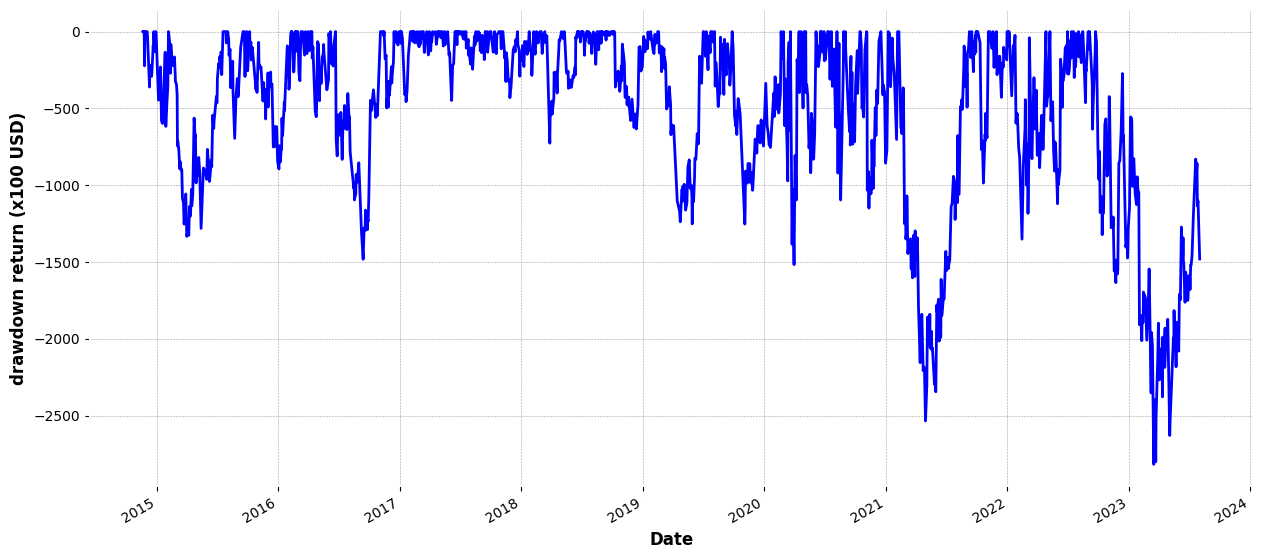

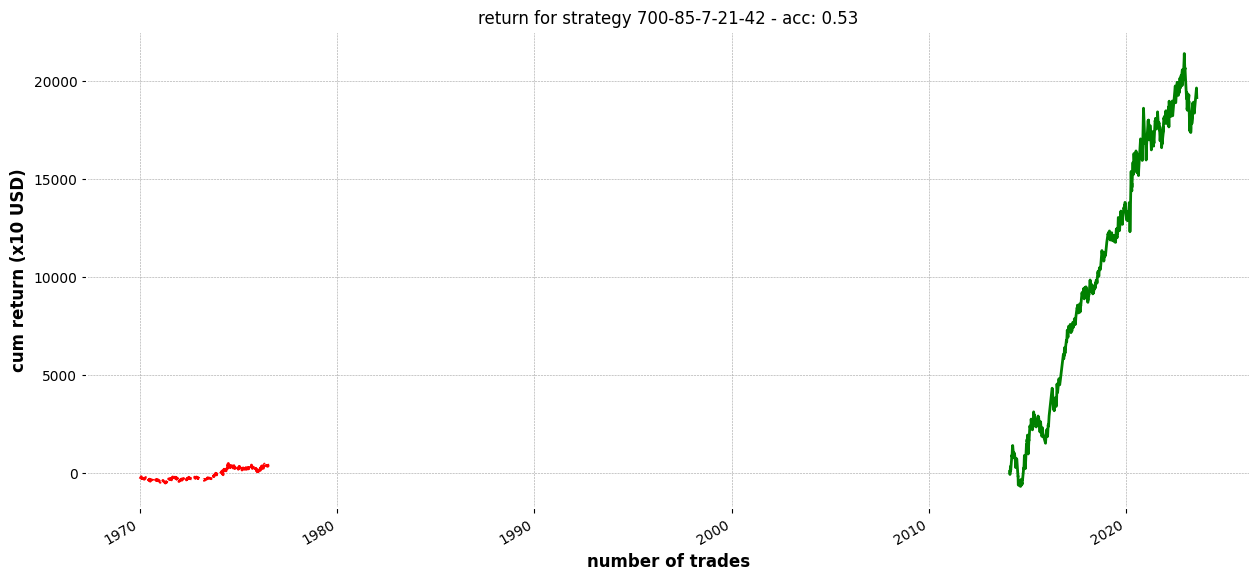

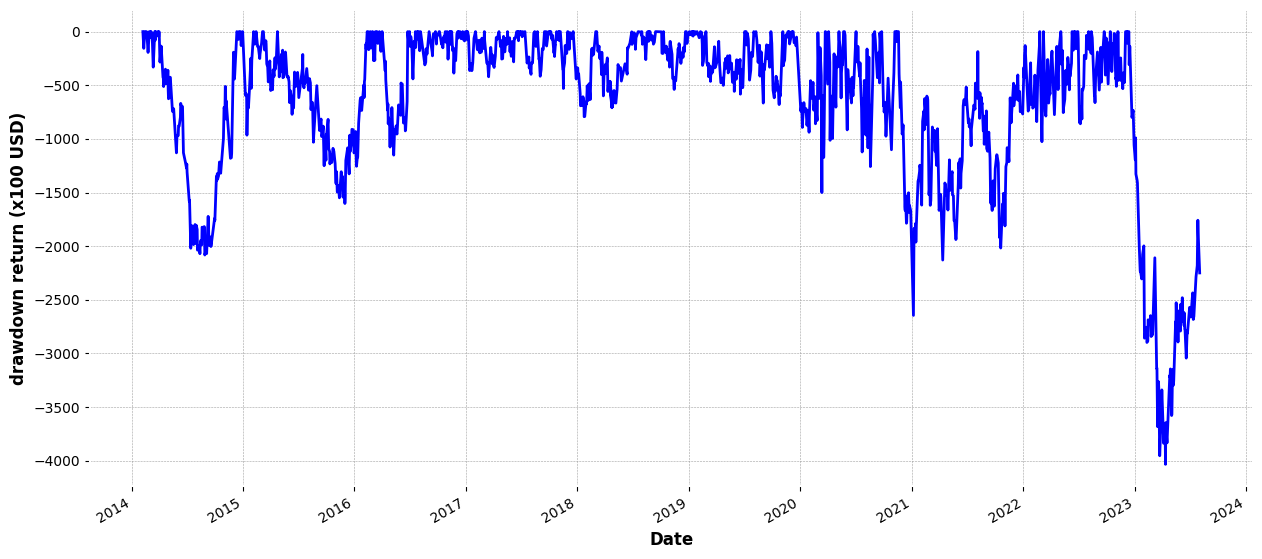

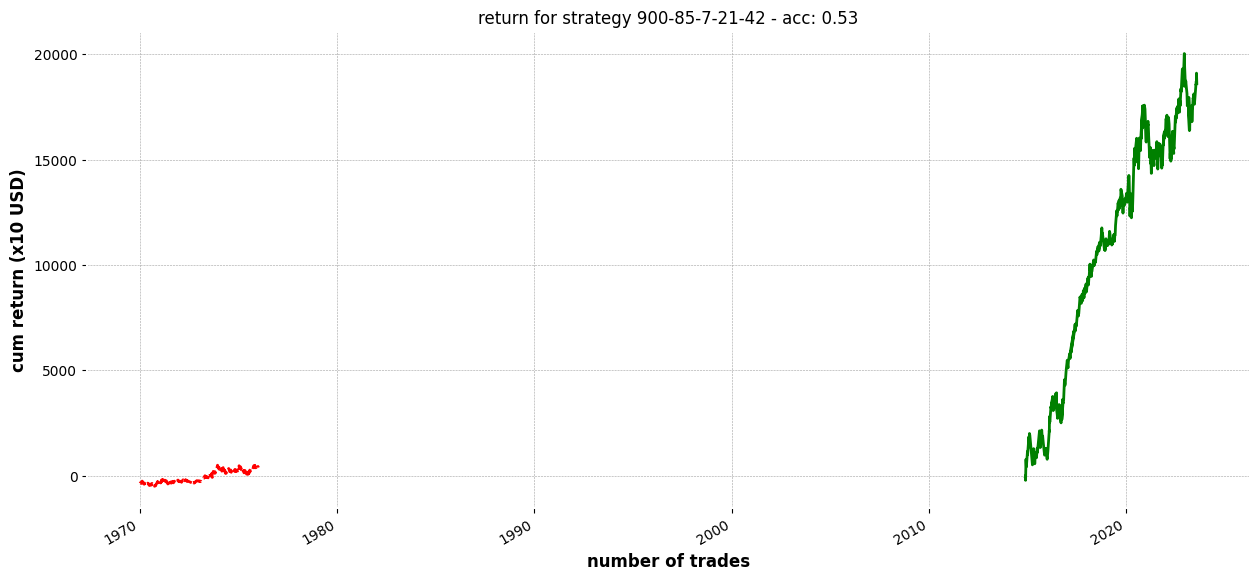

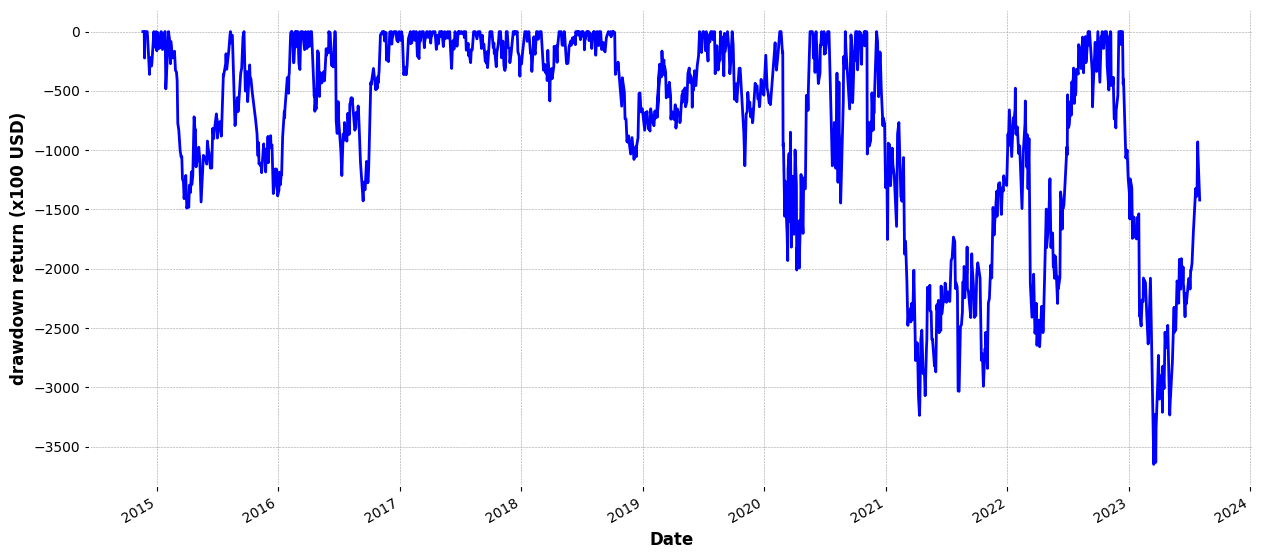

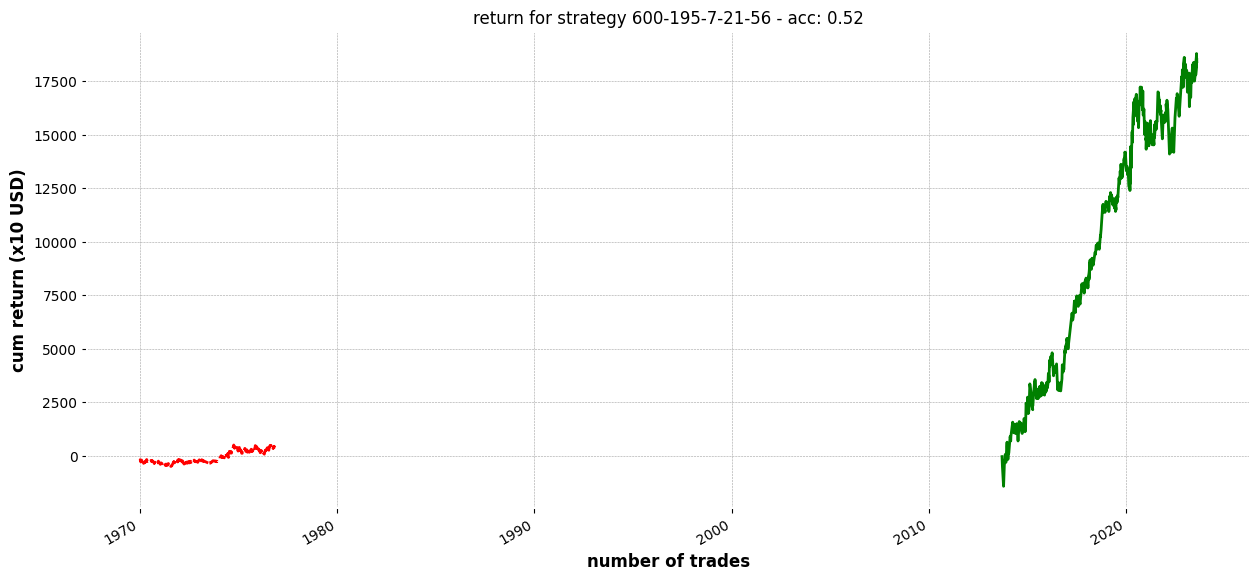

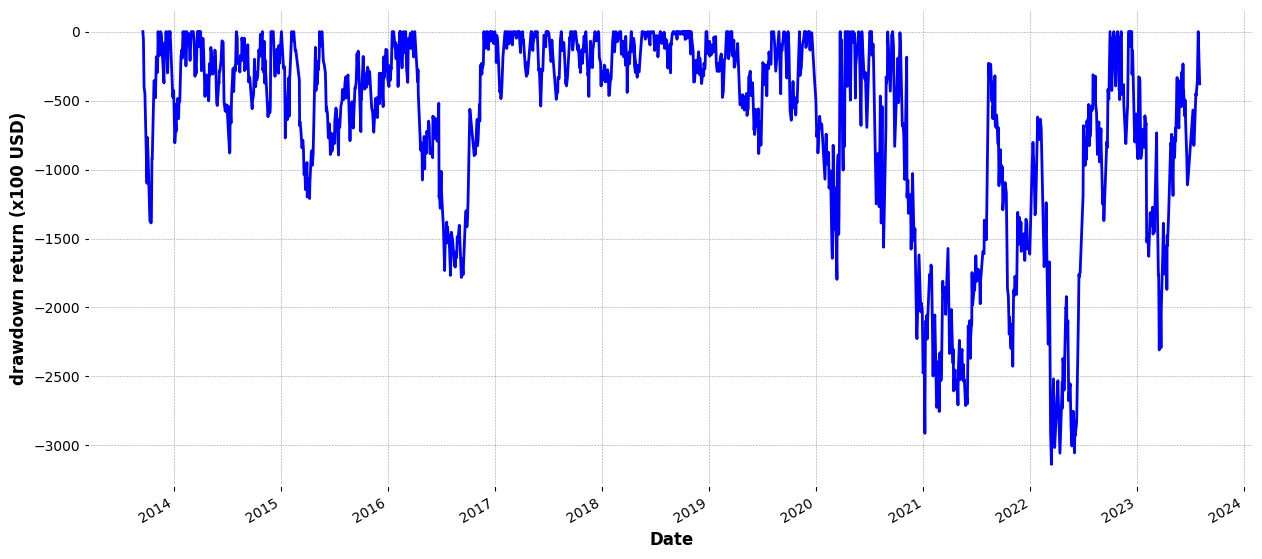

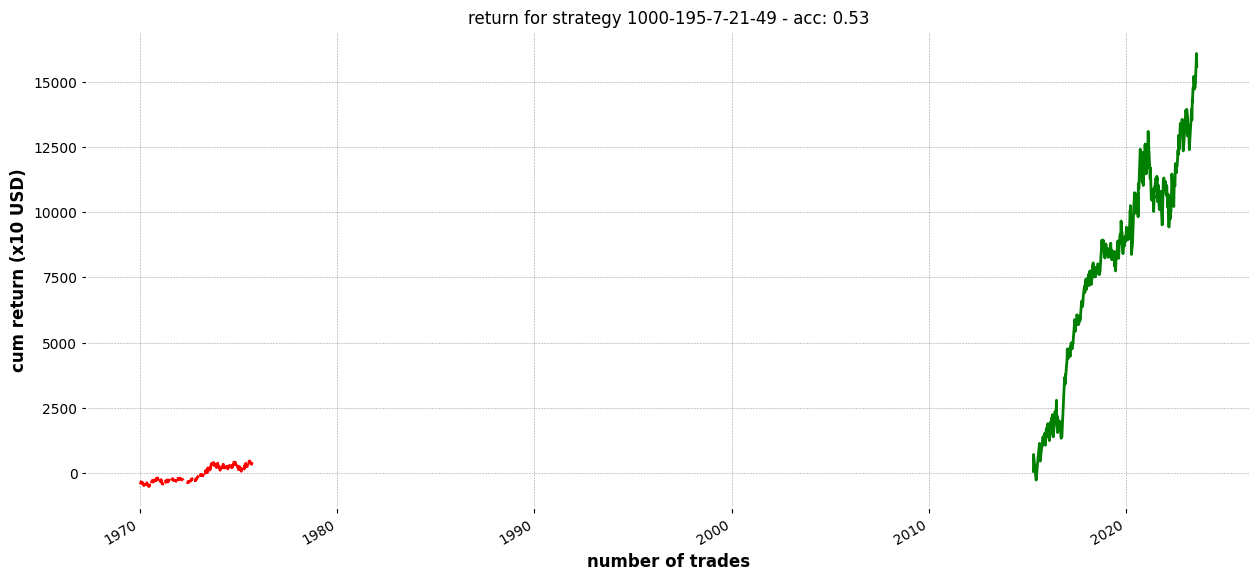

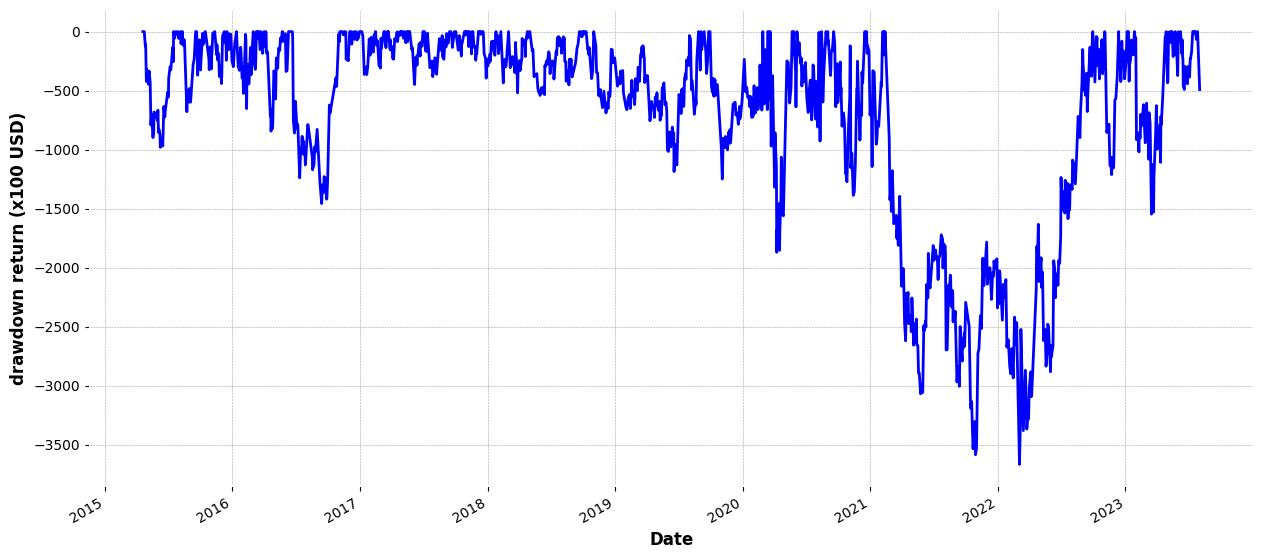

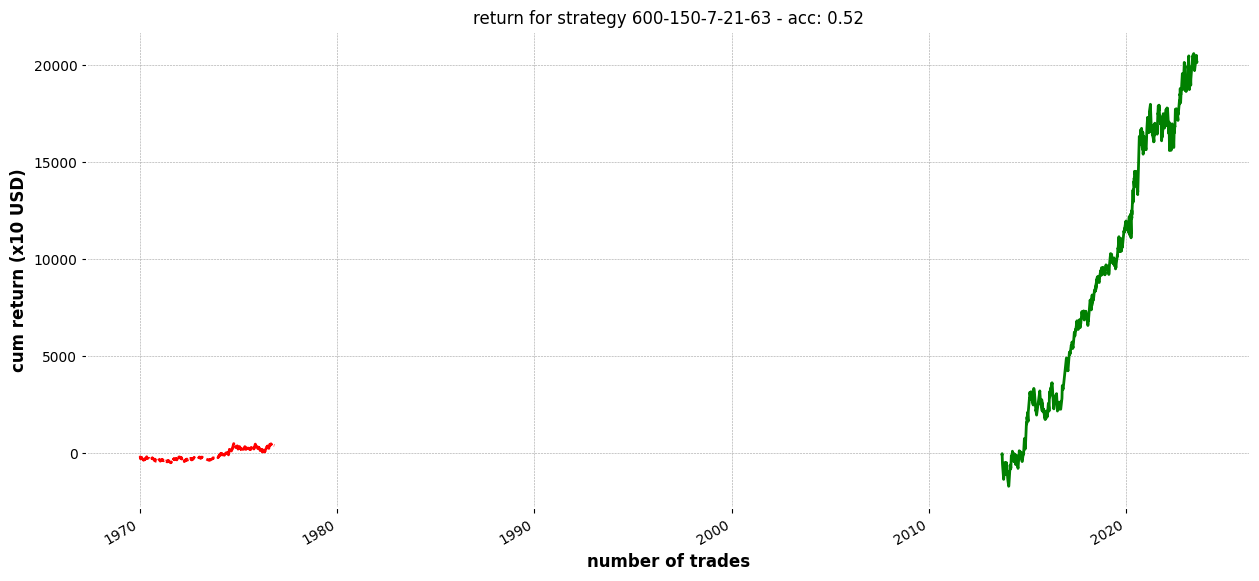

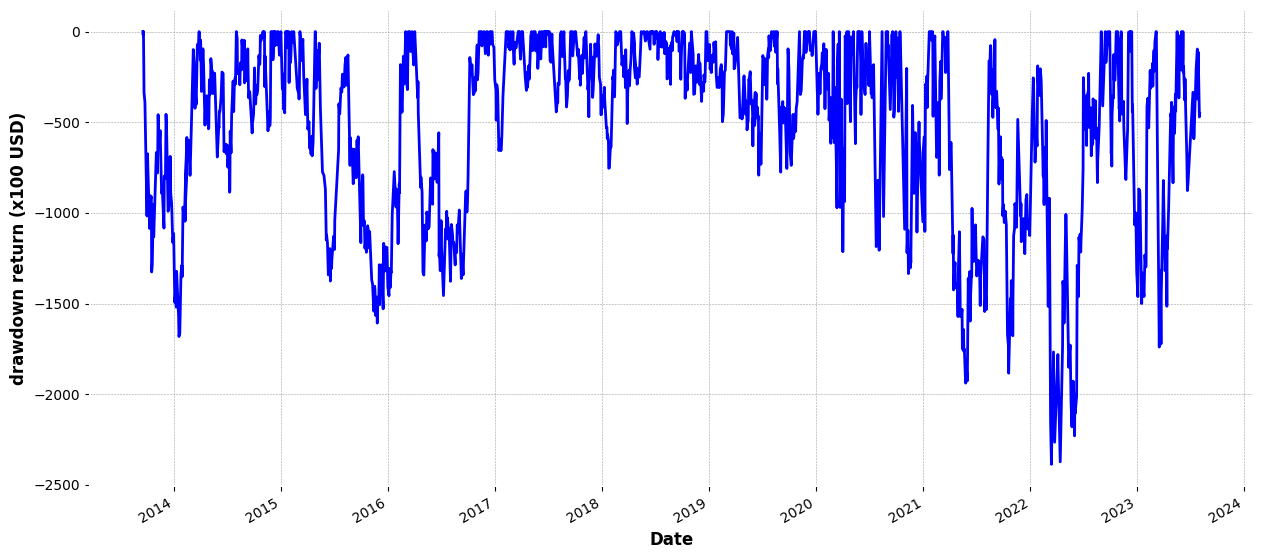

In [28]:
spl1, est1, emaf1, emas1, emass1 = 800,195, 7, 21, 35  #1
spl4, est4, emaf4, emas4, emass4 = 900,65, 7, 21, 35  #Good
spl5, est5, emaf5, emas5, emass5 = 900,115, 7, 21, 35  #Good
spl6, est6, emaf6, emas6, emass6 = 900,150, 7, 21, 35   #Good
spl7, est7, emaf7, emas7, emass7 = 900,195, 7, 21, 35  #Good
spl8, est8, emaf8, emas8, emass8 = 700,85, 7, 21, 42  #Good
spl9, est9, emaf9, emas9, emass9 = 900,85, 7, 21, 42 #Good
spl10, est10, emaf10, emas10, emass10 = 600,195, 7, 21, 56 #Good
spl11, est11, emaf11, emas11, emass11 = 1000,195, 7, 21, 49 #Good
spl12, est12, emaf12, emas12, emass12 = 600,150, 7, 21, 63 #Good



rf1,XTrain,cum1, pred1,dd1 = train_validate(data_raw, spl1, est1, emaf1, emas1, emass1)
rf4,XTrain,cum4, pred4,dd4 = train_validate(data_raw, spl4, est4, emaf4, emas4, emass4)

rf5,XTrain,cum5, pred5,dd5 = train_validate(data_raw, spl5, est5, emaf5, emas5, emass5)
rf6,XTrain,cum6, pred6, dd6 = train_validate(data_raw, spl6, est6, emaf6, emas6, emass6)

rf7,XTrain,cum7, pred7, dd7 = train_validate(data_raw, spl7, est7, emaf7, emas7, emass7)
rf8,XTrain,cum8, pred8, dd8 = train_validate(data_raw, spl8, est8, emaf8, emas8, emass8)

rf9,XTrain,cum9, pred9, dd9 = train_validate(data_raw, spl9, est9, emaf9, emas9, emass9)
rf10,XTrain,cum10, pred10, dd10 = train_validate(data_raw, spl10, est10, emaf10, emas10, emass10)
rf11,XTrain,cum11, pred11, dd11 = train_validate(data_raw, spl11, est11, emaf11, emas11, emass11)
rf12,XTrain,cum12, pred12, dd12 = train_validate(data_raw, spl12, est12, emaf12, emas12, emass12)

equity_total = pred1 + pred4 + pred5 + pred6 + pred7 + pred8 + pred9 + pred10 + pred11 + pred12
cum_total = equity_total.cumsum()
cum_max = cum_total.cummax()
dd_total = cum_total - cum_max


In [29]:
equity_total.tail

<bound method NDFrame.tail of Date
2013-09-15 22:00:00+00:00       NaN
2013-09-16 22:00:00+00:00       NaN
2013-09-17 22:00:00+00:00       NaN
2013-09-18 22:00:00+00:00       NaN
2013-09-19 22:00:00+00:00       NaN
                              ...  
2023-07-26 22:00:00+00:00    1460.0
2023-07-27 22:00:00+00:00    -678.0
2023-07-30 22:00:00+00:00   -2190.0
2023-07-31 22:00:00+00:00   -1390.0
2023-08-01 22:00:00+00:00    -160.0
Length: 2488, dtype: float64>

<Axes: xlabel='Date'>

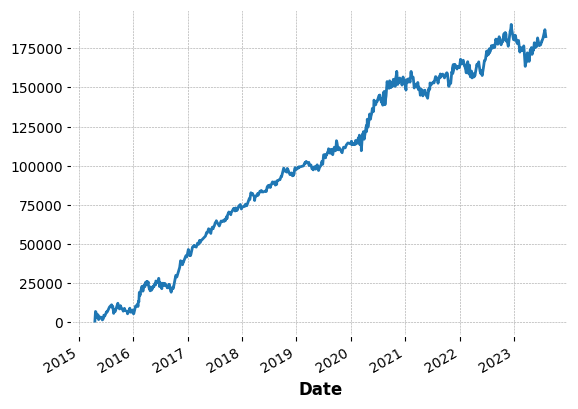

In [30]:
cum_total.plot()

<Axes: xlabel='Date'>

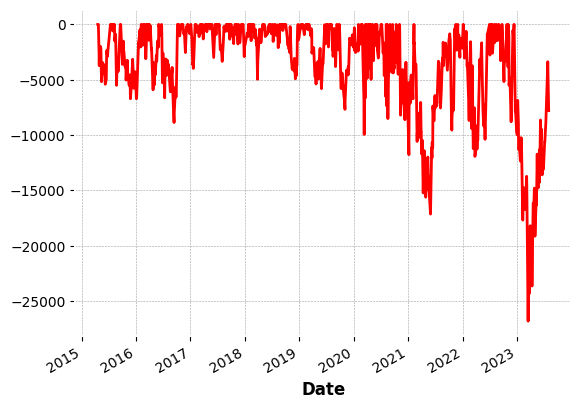

In [31]:
dd_total.plot(color='red')

In [32]:
def live_predict(rf, tsplit, fast, slow, twoslow):

  #Generate features
  data = featurize(data_raw, fast, slow, twoslow)

  #Define the training set
  X = data.drop(drop_feature_list, axis = 1)
  X = X.dropna()

  #train_test split - temporal split
  tsplit = tsplit
  XTrain = X[:tsplit]
  XTest = X[tsplit+1:]

  #Normalize features
  for feature in feature_list:
    if feature in XTrain.columns:
      minmaxsc_1 = MinMaxScaler()
      XTrain[feature] = minmaxsc_1.fit_transform(XTrain[feature].values.reshape(-1,1))
      XTest[feature] = minmaxsc_1.transform(XTest[feature].values.reshape(-1,1))
    else:
      pass

  ## Making the predictions
  predRF = pd.Series(rf.predict(XTest))
  predRF = pd.Series([1 if var > 0.5 else 0 for var in predRF])
  predRF.index = XTest.index

  return predRF

rf7,XTrain,cum7, pred7 = train_validate(data_raw,500,5, 7, 21, 35)
rf8,XTrain,cum8, pred8 = train_validate(data_raw,700,5, 7, 21, 35)
rf9,XTrain,cum9, pred9 = train_validate(data_raw,900,5, 7, 21, 49)


In [33]:
dir1 = live_predict(rf1, spl1,emaf1, emas1, emass1).iloc[-1:]
dir4 = live_predict(rf4, spl4,emaf4, emas4, emass4).iloc[-1:]
dir5 = live_predict(rf5, spl5,emaf5, emas5, emass5).iloc[-1:]
dir6 = live_predict(rf6, spl6,emaf6, emas6, emass6).iloc[-1:]
dir7 = live_predict(rf7, spl7,emaf7, emas7, emass7).iloc[-1:]
dir8 = live_predict(rf8, spl8,emaf8, emas8, emass8).iloc[-1:]
dir9 = live_predict(rf9, spl9,emaf9, emas9, emass9).iloc[-1:]
dir10 = live_predict(rf10, spl10,emaf10, emas10, emass10).iloc[-1:]
dir11 = live_predict(rf11, spl11,emaf11, emas11, emass11).iloc[-1:]
dir12 = live_predict(rf12, spl12,emaf12, emas12, emass12).iloc[-1:]


In [34]:
# Sum of buy and sell signals
buy = []
sell = []
for trade in [dir1,dir4, dir5, dir6, dir7, dir8, dir9, dir10, dir11, dir12]:
  if trade.values == 1:
    buy.append(1)
  else:
    sell.append(1)

print(f'The number of buy orders are {np.sum(buy)}') 
print(f'The number of sell orders are {np.sum(sell)}') 
np.sum(buy) - np.sum(sell)


The number of buy orders are 10
The number of sell orders are 0.0


10.0

In [35]:
print(f'{dir1} {dir4} {dir5} {dir6} {dir7} {dir8} {dir9} {dir10} {dir11} {dir12}')

Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64 Date
2023-08-02 22:00:00+00:00    1
dtype: int64


In [36]:
## Plot the histogram of the predictions
import plotly.express as px
#add line in between the histogram bars
px.histogram(pred1, pred8.values, nbins=100, title='Histogram of predictions', 
             opacity=0.8, color_discrete_sequence=['indianred'], template='plotly_white').update_traces(marker_line_width=0.5, marker_line_color="black")
              




In [37]:
# mean of negative returns and mean of positive returns
def mean_neg_pos_returns(pred):
    results = pred
    neg_returns = results[results < 0]
    pos_returns = results[results > 0]
    return neg_returns.mean(), pos_returns.mean()

In [38]:
for i in [pred1, pred11, pred12, pred4,
          pred5, pred6, pred7, pred8, pred10]:
  print(mean_neg_pos_returns(i))


(-93.48417132216021, 95.65894039735096)
(-93.52235772357733, 98.00546448087427)
(-89.41092436974792, 98.03563129357087)
(-93.54311199207143, 97.4339300937766)
(-92.93984220907302, 97.97431506849313)
(-91.81409001956953, 99.00086206896547)
(-92.20176297747311, 98.65374677002582)
(-91.56014362657095, 95.56466876971609)
(-90.59797297297297, 96.91210485736316)


## Using Random Forest algo to make predictions on next day price direction



In [39]:
# Get feature importances from the model
feature_importances = rf1.feature_importances_

# Create a dataframe for visualization
importances_df = pd.DataFrame({
    'Feature': XTrain.columns,
    'Importance': feature_importances
})

# Sort the dataframe by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

importances_df

,Feature,Importance
1,close1MinusMaFast,0.144165
0,closeMinusMaFast,0.107562
8,MaSlowMinusMa2Slow,0.096384
4,closeMinusHigh_7,0.095490
5,closeMinusLow_7,0.090717
2,closeMinusMaSlow,0.085634
6,lowMinusLow_7,0.083765
3,MaFastMinusMaSlow,0.083065
7,MaFastMinusMa2Slow,0.075589
12,sum_bull_lag,0.032152
